##### Article list
* machine learning / ai
* how machine learning works
* machine learning algorithms
    * Supervised -> linear / logistic regression, svm, Decision trees, Random forests, k-NN, Neural networks, Naive bayes - explain with 1/2 problems
    * Unsupervised -> K-Means Clustering, Hierarchical Clustering, Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE), Gaussian Mixture Models (GMM), Autoencoders, Self-Organizing Maps (SOM), DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
    * Semi-Supervised -> Self-training, Co-training, Generative Models (Generative Adversarial Networks)
    * Reinforcement -> Q-Learning, Deep Q-Networks (DQN), Policy Gradient Methods, Actor-Critic Methods, Deep Deterministic Policy Gradient (DDPG), Proximal Policy Optimization (PPO)
    * Ensemble -> Bagging (Bootstrap Aggregating), Boosting (e.g., AdaBoost, Gradient Boosting), Stacking, Voting Classifiers
    * Deep Learning -> CNN, RNN, LSTM, Gated Recurrent Units (GRU), Transformer Models, Capsule Networks, Variational Autoencoders (VAE), Generative Adversarial Networks (GAN)
    * Anomaly Detection -> Isolation Forest, One-Class SVM, Autoencoders, Local Outlier Factor (LOF)
    * Dimensionality Reduction -> Principal Component Analysis (PCA), Linear Discriminant Analysis (LDA), t-Distributed Stochastic Neighbor Embedding (t-SNE), Autoencoders
    * Feature Selection -> Recursive Feature Elimination (RFE), Feature Importance (e.g., from tree-based models), Lasso Regression
* AI algorithms

* research topic
    * how ai can reduced improve the environment

### Vision input output

raw image -> numerical encoding -> model -> output -> predicted output <br>

* input shapes
```[batch_size, width, height, color_channel]``` ex: [None, 224, 224, 3], [32, 224, 224, 3]

batch_size is problem specific depending on hardware

* output shape: number of class [n, ....]

Different input shapes (for different frameworks):
1. shape -> [None, 28, 28, 1] (NHWC)
2. shape -> [None, 1, 28, 28] (NCHW)

##### Path to build
* Get the data ready (convert to tensors)
* Build or pick a model - Pick a loss function, Build a training loop
* Fit the model to the data and make prediction
* Evaluate the model
* Improve through experimentation
* Save and reload the trained model

#### CNN
- Convolutional layer - 'requires input data, filter (feature detector/kernel), featuremap'
`nb`: we have a feature detector, also known as a kernel or a filter, which will move across the receptive fields of the image, checking if the feature is present. This process is known as a convolution.
- Pooling layer
- Fully-connected layer

#### Libs
* `torchvision.datasets` - get datasets and data loading function for computer vision here
* `torchvision.models` - pytorch pre-trained modesl
* `torchvision.transforms` - functions  for manipulating vision data to be suitable for use with
* `torch.utils.data.Dataset` - Base dataset class for pytorch
* `torch.utils.data.DataLoader` - create python iterable over a

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

1. Getting dataset
`FashionMNIST`

In [2]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]

type(image)

torch.Size([1, 28, 28])

In [5]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Image size: torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

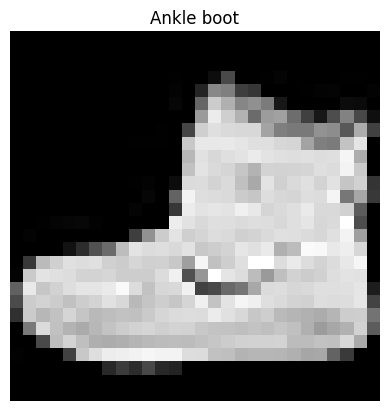

In [6]:
image, label = train_data[0]
print(f'Image size: {image.shape}')

plt.imshow(image.permute(1,2,0), cmap='gray')
plt.title(label=class_names[label])
plt.axis(False)

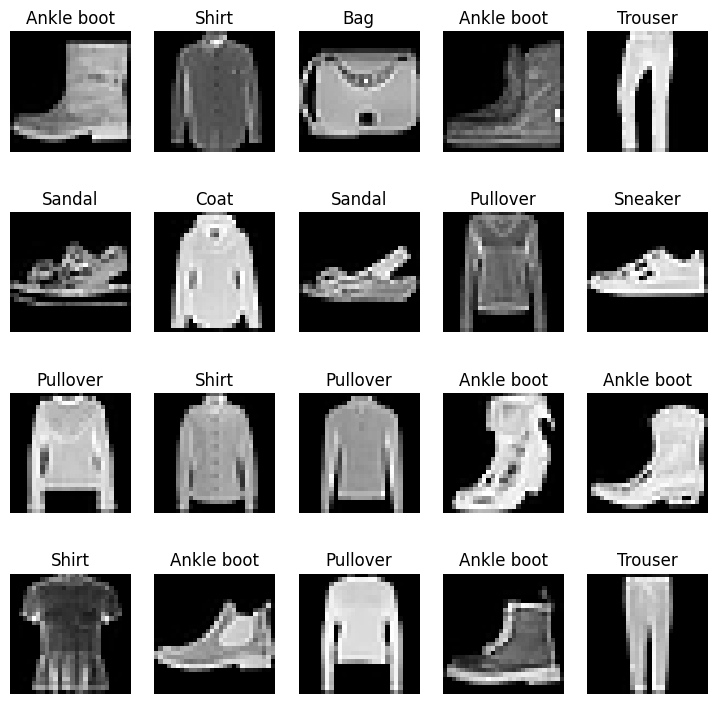

In [7]:
# plot more
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 5
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=(1, )).item()
    # print(random_idx)
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [8]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

#### 2. prepare dataloader

Now dataset is in form of pytorch datasets.
DataLoader turns dataset into a python iterable or turn into mini-batches

1. its more computationally efficient as in computing hardware
2. it gives our neural network more chanaces to update its gradients per epoch

dataloader: https://pytorch.org/docs/stable/data.html

In [9]:
from torch.utils.data import DataLoader

# setup batch size hyperparameter
BATCH_SIZE = 32

# turn datasets intor iterables
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b6c4b5f39a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b6c4970f670>)

In [10]:
next(iter(['a', 'b', 'c', 'd']))


'a'

In [11]:
print(f'Dataloader: {train_dataloader, test_dataloader}')
print(f'Length: train - {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Lenght: test - {len(test_dataloader)} batches of {BATCH_SIZE}')

Dataloader: (<torch.utils.data.dataloader.DataLoader object at 0x7b6c4b5f39a0>, <torch.utils.data.dataloader.DataLoader object at 0x7b6c4970f670>)
Length: train - 1875 batches of 32
Lenght: test - 313 batches of 32


torch.Size([32, 1, 28, 28]) torch.Size([32])
Image size: torch.Size([1, 28, 28])
Label: 7, label shape: torch.Size([])


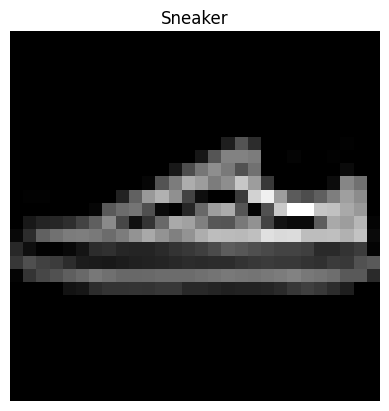

In [12]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)
# show a sample from dataloader
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f'Image size: {img.shape}')
print(f'Label: {label}, label shape: {label.shape}')

In [13]:
len(train_features_batch)

32

#### Create model0

build a baseline model

In [14]:
# flatten layer
flatten_model = nn.Flatten()

# get a single sample
x = train_features_batch[0]

# flatten the sample
output = flatten_model(x)

print(f'Shape before flattening: {x.shape}')
print(f'Shape after flattening: {output.shape}')

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [15]:
input = torch.randn(32, 1, 5, 5)

# flatten = nn.Flatten()
# output1 = flatten(input)
# output2 = flatten(output1)
# output2.size()
# print(input)
# output.squeeze()

In [16]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int,  output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [17]:
torch.manual_seed(42)

# setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=28*28, # or 784
    hidden_units=10, # how many units in the hidden layer
    output_shape=len(class_names) # one for every class
).to('cpu')

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [18]:
dummy_x = torch.rand([1, 1, 28, 28])

model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [19]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

#### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - `nn.CrossEntropyLoss()`
* Optimizer - `torch.optim.SGD()`
* Evaluation metric - since we are working on classification problem, lets use accuracy as our evaluation metric

In [20]:
import requests
from pathlib import Path

urls = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py'

# download helper function
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists.')
else:
    print('Downloading helper_function.py')
    request = requests.get(url=urls)
    with open('helper_functions.py', 'wb') as file:
        file.write(request.content)


helper_functions.py already exists.


In [21]:
# import accuracy metric
from helper_functions import accuracy_fn

# setup loss funtion and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


### 3.2 Creating a function to time our experiments

ml is experimental.

2 main things often want to track are:
1. Models performance (loss and accuracy value)
2. How fast it runs


In [22]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    """ difference between start and end time """
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')
    return total_time


In [23]:
start_time = timer()

end_time = timer()
print_train_time(start=start_time, end=end_time, device='cpu')


Train time on cpu: 0.000 seconds


2.8563001251313835e-05

#### Creating a training loop and trainning a model on batches of data
The optimizer will update a models parameters once per batch rather than once per epoch

## Creating a training loop and training a model on batches of data
1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*
4. print out whats happening
5. Time it all

In [24]:
#import tqdm for progress bar
from tqdm.auto import tqdm

# set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# create the training and test loop
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-------------')
    ### training
    train_loss = 0

    # add a loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate the loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        if batch % 400 == 0:
            print(f'Looked at {batch * len(X)}/{len(train_dataloader.dataset)}')

# divide total train loss by lenght of train dataloader
train_loss /= len(train_dataloader)


### Testing loop
test_loss, test_acc = 0, 0
model_0.eval()
with torch.inference_mode():
    for X_test, y_test in test_dataloader:
        # 1. forward pass
        # test_pred_logits = model_0(X_test)
        test_pred = model_0(X_test)

        # 2. Calculate loss (accumulatively)
        test_loss += loss_fn(test_pred, y_test)

        # 3. Calculate accuracy
        test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

# Prints whats happen
print(f'\n Train loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test acc: {test_acc:.4f}')

train_time_end_on_cpu = timer()

total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
Epoch: 1
-------------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
Epoch: 2
-------------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

 Train loss: 0.4532 | Test Loss: 0.5109, Test acc: 82.3782
Train time on cpu: 15.660 seconds


### Get predictions and model_0 results

In [38]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=None):
    """ Returns a dictionary containing the results of model predicting on data_loader """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc to fund the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}


# Calculate model 0 results on test datasets
model_0_results = eval_model(model=model_0, 
                            data_loader=test_dataloader, 
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device='cpu')

model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5108762383460999,
 'model_acc': 82.37819488817891}

#### Setup device agnostic code (GPU)

In [27]:
torch.cuda.is_available()
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### building model with non-linearrity

In [28]:
# create a model with non-linear and linear layers

class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int,
                hidden_units: int,
                output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # input into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [29]:
next(model_0.parameters()).device

device(type='cpu')

In [39]:
# create an instance model
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device) # send the gpu if available


next(model_1.parameters()).device

device(type='cpu')

#### 6.1 Setup Loss, Optimizer and Evaluation metrics

In [31]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)


#### Functionizing training and evaluation / testing loop
* training loop - train_step()
* testing_loop - test_step()

In [32]:
def train_step(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    # Traning
    
    """Performs a training with model trying to learn on data_loader"""
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(data_loader):
        model.train()
        # 1. forward pass
        y_pred = model(X)
        
        # 2. calculate loss & accuracy(per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # 3. optimizer zero grad
        optimizer.zero_grad()
        
        # 4. loss backward
        loss.backward()
        
        # 5. optimizer step (update the models parameters once *per batch*)
        optimizer.step()
        
        # print out whats happen
        # if batch % 400 == 0:
        #     print(f'Looked at {batch * len(X)}/{len(data_loader.dataset)} samples.')
            
    # devide the total train loss and accuracy of data_loader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%\n')

In [33]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, 
              accuracy_fn,
              device: torch.device = device):
    
    test_loss, test_acc = 0, 0
    
    # model in eval mode
    model.eval()
    
    # turn on inference mode context manager
    with torch.inference_mode():
        for X_test, y_test in data_loader:    
            # send the data to the target device
            X_test, y_test = X_test.to(device), y_test.to(device)
            # 1. forward pass (output raw logits)
            test_pred = model(X_test)
            # 2. calculate the loss & accuracy
            loss = loss_fn(test_pred, y_test)
            test_loss += loss
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
        
        # adjust matrics and printout
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f'Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n')

In [34]:
torch.manual_seed(42)

# measure time
from timeit import default_timer as Timer
train_time_start_on_cpu = timer()

# set epochs
epochs = 20

# create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f'-----------Epoch: {epoch}---------\n')
    train_step(
        model=model_1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    
    test_step(
        model=model_1,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_on_cpu = timer()
total_train_time_model_1 = print_train_time(
    start=train_time_start_on_cpu, 
    end=train_time_end_on_cpu,
    device=device
)

  0%|          | 0/20 [00:00<?, ?it/s]

-----------Epoch: 0---------

Train loss: 1.09199 | Train acc: 61.34%

Test loss: 0.95636 | Test acc: 65.00%

-----------Epoch: 1---------

Train loss: 0.78101 | Train acc: 71.93%

Test loss: 0.72227 | Test acc: 73.91%

-----------Epoch: 2---------

Train loss: 0.67027 | Train acc: 75.94%

Test loss: 0.68500 | Test acc: 75.02%

-----------Epoch: 3---------

Train loss: 0.64384 | Train acc: 76.52%

Test loss: 0.65079 | Test acc: 76.13%

-----------Epoch: 4---------

Train loss: 0.62892 | Train acc: 77.00%

Test loss: 0.65277 | Test acc: 75.95%

-----------Epoch: 5---------

Train loss: 0.61576 | Train acc: 77.41%

Test loss: 0.64104 | Test acc: 76.50%

-----------Epoch: 6---------

Train loss: 0.60668 | Train acc: 77.78%

Test loss: 0.62651 | Test acc: 76.61%

-----------Epoch: 7---------

Train loss: 0.45148 | Train acc: 83.94%

Test loss: 0.45020 | Test acc: 84.39%

-----------Epoch: 8---------

Train loss: 0.39916 | Train acc: 85.95%

Test loss: 0.43955 | Test acc: 84.86%

----------

In [35]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5108762383460999,
 'model_acc': 82.37819488817891}

In [36]:
print(total_train_time_model_0)
print(total_train_time_model_1)

15.659790628997143
133.4094108279969


In [40]:
# get model_1 results dictionary
model_1_results = eval_model(model=model_1,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)

model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 2.3021068572998047,
 'model_acc': 10.75279552715655}

#### Model 2: building convolutional neural network (cnn)

* CNN's are also known ConvNets.
* CNN's are known for their capabilities to find patterns in visual data

https://poloclub.github.io/cnn-explainer/

In [42]:
### build CNN
class FashionMNISTModelV2(nn.Module):
    """
        Model architecture that replicates the TinyVGG
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            # check hyperparameters
            nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=1,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # For tracing this problem
            # `UserWarning: Initializing zero-element tensors is a no-op
            # warnings.warn("Initializing zero-element tensors is a no-op")`  
            # in_features=hidden_units*0 -> `hidden_units*0`
            
            nn.Linear(in_features=hidden_units*0,
                      out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        print(f'block-1: {x.shape}')
        x = self.conv_block_2(x)
        print(f'block-2: {x.shape}')
        x = self.classifier(x)
        return x

In [43]:
torch.manual_seed(42)
# input shape is based on image color channels
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)


/home/sudiptoshahin/anaconda3/envs/dreamflow-new/lib/python3.9/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [44]:
next(model_2.parameters())

Parameter containing:
tensor([[[[ 0.2548,  0.2767, -0.0781],
          [ 0.3062, -0.0730,  0.0673],
          [-0.1623,  0.1958,  0.2938]]],


        [[[-0.2445,  0.2897,  0.0624],
          [ 0.2463,  0.0451,  0.1607],
          [-0.0471,  0.2570,  0.0493]]],


        [[[-0.1556,  0.0850, -0.1536],
          [-0.0391, -0.1354,  0.2211],
          [-0.2631, -0.1537, -0.0941]]],


        [[[-0.2004,  0.0315, -0.3292],
          [ 0.3010, -0.2832,  0.2573],
          [ 0.0555, -0.1082,  0.2060]]],


        [[[ 0.0520,  0.2693,  0.0364],
          [-0.1051,  0.0896, -0.0904],
          [ 0.1403,  0.2976,  0.1927]]],


        [[[-0.1457,  0.1924,  0.0596],
          [ 0.1693, -0.2032, -0.3300],
          [-0.1288, -0.2557,  0.2735]]],


        [[[ 0.0960,  0.1381,  0.1054],
          [-0.0058,  0.2609, -0.2368],
          [ 0.0210, -0.2275,  0.1028]]],


        [[[-0.1148,  0.1021, -0.0694],
          [ 0.2765, -0.1976, -0.1988],
          [-0.1988,  0.2998,  0.1111]]],


        [[

#### stepping through Conv2d

In [45]:
torch.manual_seed(42)

# create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f'Image batch shape: {images.shape}')
print(f'Single image shape: {test_image.shape}')
print(f'Test image\n: {test_image}')

test_image.shape

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image
: tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

torch.Size([3, 64, 64])

In [46]:
# create single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(2, 2),
                       stride=1,
                       padding=0)

# pass the data through the convolutional layer
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 63, 63])

In [47]:
test_image.unsqueeze(0)

tensor([[[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
          [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
          [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
          ...,
          [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
          [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
          [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

         [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
          [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
          [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
          ...,
          [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
          [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
          [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

         [[-0.7978,  1.0261,  1.1465,  ...,  1.2134,  0.9354, -0.0780],
          [-1.4647, -1.9571,  

#### stepping through MaxPool2d

In [48]:
print(f'Test image original shape: {test_image.shape}')
print(f'Test image with unsqueeze dimension: {test_image.unsqueeze(0).shape}')

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueeze dimension: torch.Size([1, 3, 64, 64])


# 17:59:41